<a href="https://colab.research.google.com/github/IgnatiusEzeani/IGBONLP/blob/master/ig_en_mt/scripts_notebooks/2.%20Transformer%20MT%20Model%20for%20Igbo-English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer MT Model for Igbo-English

In this work, we discuss our effort toward building a standard evaluation benchmark dataset for Igbo-English machine translation tasks.

## Table of Content

<!-- [TOC] -->
<div class="toc">
<ol>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#evaldataset">Evaluation Dataset</a></li>
<li><a href="#buildingModel">Building the Igbo-English Translation Model</a>
<li><a href="#transformerModel">Overview of the Transformer Model</a></li> 
<li><a href="#dataprep">Data Preparation</a></li>

<li><a href="#acknowledgement">Acknowledgement</a></li>
</ol>
</div>

<a id="introduction"></a>
## Introduction

[Igbo language](https://en.wikipedia.org/wiki/Igbo_language) is one of the 3 major Nigerian languages spoken by approximately 50 million people globally, 70% of whom are in southeastern Nigeria. It is low-resourced in terms of natural language processing. IGBONLP despite some efforts toward developing IgboNLP such as part-of-speech tagging: [Onyenwe et al. (2014)](http://eprints.whiterose.ac.uk/117817/1/W14-4914.pdf), [Onyenwe et al. (2019)](https://www.researchgate.net/publication/333333916_Toward_an_Effective_Igbo_Part-of-Speech_Tagger); and diacritic restoration: [Ezeani et al. (2016)](http://eprints.whiterose.ac.uk/117833/1/TSD_2016_Ezeani.pdf), [Ezeani et al. (2018)](https://www.aclweb.org/anthology/N18-4008).

Although there are existing sources for collecting Igbo monolingual and parallel data, such as the [OPUS Project (Tiedemann, 2012)](http://opus.nlpl.eu/) or the [JW.ORG](https://www.jw.org/ig), they have certain limitations. The OPUS Project is a good source training data but, given that there are no human validations, may not be good as an evaluation benchmark. JW.ORG contents, on the other hand, are human generated and of good quality but the genre is often skewed to religiouscontexts and therefore may not be good for building a generalisable model.

This project focuses on creating and publicly releasing a standard evaluation benchmark dataset for Igbo-English machine translation research for the NLP research community. This project aims to build, maintain and publicly share a standard benchmark dataset for Igbo-English machine translation research.

<a id="evaldataset"></a>
## Evaluation Dataset
The evaluation dataset was created using the approach laid out in the paper: [Igbo-English Machine Translation: An Evaluation Benchmark](https://eprints.lancs.ac.uk/id/eprint/143011/1/2004.00648.pdf).

There are 5 key objectives:
1. To create a minimum of 10,000 English-Igbo human-level quality sentence pairs mostly from the news domain
2. To assemble and clean a minimum of 100,000 monolingual Igbo sentences, mostly from the news domain, as companion monolingual data for training Igbo language models
3. To train a translation model with from a large, synthetically collected dataset (e.g [JW300](http://opus.nlpl.eu/JW300.php)) using a standard NMT architecture or framework (e.g. [JoeyNMT](https://joeynmt.readthedocs.io/en/latest/) on the [Masakhane](https://github.com/IgnatiusEzeani/masakhane-mt/tree/master/benchmarks) platform)
4. To apply the trained MT model to the human-validated benchmark dataset  
5. To release the dataset to the research community as well as present it at a conference and publish a journal paper that details the processes involved.

Al available data can be accessed from [IGBONLP GitHub Repo](https://github.com/IgnatiusEzeani/IGBONLP/tree/master/ig_en_mt).

<a id="buildingModel"></a>
## Building the Igbo-English Translation Model
With this Jupyter notebook, we present a simple usage demo of the evaluation benchmark dataset which was reported in the [paper](https://eprints.lancs.ac.uk/id/eprint/143011/1/2004.00648.pdf). We will also be building a `Transformer` based neural machine translation model for Igbo-English machine translation, using [PyTorch](https://pytorch.org/) and [TorchText](https://pytorch.org/text/index.html).

<a id="transformerModel"></a>
### Overview of the Transformer Model
We will build a *Sequence-to-Sequence* (Seq2Seq) model based on the method described in the paper  [Attention is All You Need by Vaswani et al.](https://arxiv.org/abs/1706.03762).

The Transformer architecture gave rise to popular embedding models such as [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers). Pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models.

While the previous *Seq2Seq* models and their variants use a *recurrent* (LSTM and GRUs) and *convolutional* (CNN) layers with the attention mechanism, the Transformer is based *solely* on the attention mechanism, dispensing entirely with recurrence and convolutions. 

<a id="dataprep"></a>
### Data Preparation
The models will be coded in PyTorch while the data pre-processing and preparation will be done using TorchText. We will assume that these required modules have been installed: `torch`, `torchtext`, `numpy`

In [1]:
!git clone https://github.com/IgnatiusEzeani/IGBONLP.git

Cloning into 'IGBONLP'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 461 (delta 66), reused 31 (delta 9), pack-reused 367
Receiving objects: 100% (461/461), 124.88 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (267/267), done.


Change to the working directory `/content/IGBONLP/ig_en_mt/scripts_notebooks`

In [2]:
cd IGBONLP/ig_en_mt/scripts_notebooks/

/content/IGBONLP/ig_en_mt/scripts_notebooks



Let's start by making the basic imports

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import numpy as np

import random
import math
import time

We need a `tokenizer` for both languages. Here we are using a very basic one that splits the text on spaces. This is basically because the dataset has been presented in that format. Ideally, it may be necessary to use a more tailored tokenizer depending on the language and/or the task. But this will do for now.

We will then use TorchText's [Field](https://pytorch.org/text/_modules/torchtext/data/field.html) (see implemetation [here]((https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)) class to define the structure of the data. The `tokenize` argument is set to the tokenization function for both languages. The `Field` appends the "start of sequence" (`init_token`) and "end of sequence" (`eos_token`). All words are converted to lowercase.

In [0]:
def tokenize(text):
    return [token for token in text.split()]

SRC = Field(tokenize = tokenize, init_token = '<sos>', eos_token = '<eos>',
            lower = True, batch_first = True)
TRG = Field(tokenize = tokenize, init_token = '<sos>', eos_token = '<eos>',
            lower = True, batch_first = True)

We then load the evaluation data from our [dataset](https://github.com/IgnatiusEzeani/IGBONLP/tree/master/ig_en_mt/ig_parallel). So far it contains approximately ~12,000 parallel Igbo and English sentences.

We split the dataset into *train*, *validate* and *test* sets by specifying the source and target extensions (`exts`) and using the `Field` objects create above. The `exts` indicates the languages to use as the *source* and *target* (source first) and `fields` specifies which field to use for the source and target.

In [0]:
data_folder = 'benchmark_dataset' #benchmark evalset in 'benchmark_dataset', training data in 'masakhane_JW300_enig'
fields, exts = (SRC,TRG), ('.ig','.en')
train_data, validate_data, test_data = TranslationDataset.splits(fields=fields, exts=exts,
                        path=os.path.join('./..', data_folder),
                        train='train', validation='val', test='test')

To be sure that we loaded the data correctly, we can check whether the number of example we have for each split corresponds with what we expect.

In [6]:
print(f"{'Training examples':>20s}: {len(train_data.examples)}")
print(f"{'Validation examples':>20s}: {len(validate_data.examples)}")
print(f"{'Testing examples':>20s}: {len(test_data.examples)}")

   Training examples: 9999
 Validation examples: 200
    Testing examples: 542


We can also confirm that the language pairs are correctly loaded i.e. the correct *source* and *target* in their positions

In [7]:
print(vars(train_data.examples[0]))

{'src': ['akụkọ', 'ndị', 'ga-amasị', 'gị:'], 'trg': ['the', 'news', 'that', 'will', 'interest', 'you:']}


We'll set the random seeds for deterministic results.

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Next, we'll build the *vocabulary* for the source and target languages. The vocabulary is used to associate each unique token with an index (an integer). The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

It is important to note that our vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

In [0]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [10]:
print(f"Unique tokens in source (ig) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ig) vocabulary: 8881
Unique tokens in target (en) vocabulary: 10351


The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary. 

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
BATCH_SIZE = 128

train_iterator, validate_iterator, test_iterator = BucketIterator.splits(
    (train_data, validate_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

### Building the Transformer Model
The basic layout of the Transformer model is the same to other *Seq2Seq* architectures. It has three main parts:

*   the *encoder*: which encodes the input/source sentence (in target language) into a *context vector*
*   the *decoder*: which decodes this *context vector* to product the output/target sentence
*   and finally, the *Transformer* model that encapsulates both processes in a single pipeline.

Other concepts like the *attention* and the *positional embedding* will be discussed and implemented below.

#### The `Encoder` and the `EncoderLayer`

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim,
                 dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [0]:
# The EncoderLayer
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, 
                                                      dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Multi-Head Attention Layer
Also, a key concepts introduction in the [Transformer paper](https://arxiv.org/abs/1706.03762) is the *Multi-Head Attention* layer. So, in summary, we will have the *encoder*, the *decoder*, the *attention layer* within our Transformer architecture. 

In [0]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer
The Transformer has no reccurent layers and so does not have any notion of the order of the input tokens. A fixed and static *positional encoding* was used to *force* this knowledge in the original paper.

But later implementations, including BERT, introduced *positional embedding* to solve this. Here we use a max vocab size of `100` i.e. we expect the source sentence not to contain more than 100 tokens.  

In [0]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### The `Decoder` and the `DecoderLayer`

In [0]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### The Transformer Seq2Seq Model

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# Training and Testing the Transformer Seq2Seq Model

Now we have our model implemented, we can begin training it. 

First, we'll initialize our model. As mentioned before, the input and output dimensions are defined by the size of the vocabulary. The embedding dimensions and dropout for the encoder and decoder can be different, but the number of layers and the size of the hidden/cell states must be the same. 

We then define the encoder, decoder and then our Seq2Seq model, which we place on the `device`.

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.3 #0.1
DEC_DROPOUT = 0.3 #0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Let's string the encoder and decoder objects to define our Transformer based Seq2Seq model.

In [0]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

Check the number of parameters...

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,583,855 trainable parameters


The Transformer paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [23]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(8881, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (1): EncoderLayer(
        (lay

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [0]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function. The `CrossEntropyLoss` function calculates both the log softmax as well as the negative log-likelihood of our predictions. 

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up. 

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called `state_dict` in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss. 

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [29]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

print(f'-----------<Training started>-----------')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, validate_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'igen-transformer-model.pt')

    # torch.save(model.state_dict(), 'igen-transformer-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
print(f'-----------<Training ended>-----------')

-----------<Training started>-----------
Epoch: 01 | Time: 0m 14s
	Train Loss: 7.075 | Train PPL: 1181.539
	 Val. Loss: 6.123 |  Val. PPL: 456.297
Epoch: 02 | Time: 0m 13s
	Train Loss: 6.371 | Train PPL: 584.706
	 Val. Loss: 5.898 |  Val. PPL: 364.311
Epoch: 03 | Time: 0m 14s
	Train Loss: 5.852 | Train PPL: 347.943
	 Val. Loss: 5.655 |  Val. PPL: 285.837
Epoch: 04 | Time: 0m 14s
	Train Loss: 5.461 | Train PPL: 235.290
	 Val. Loss: 5.620 |  Val. PPL: 275.929
Epoch: 05 | Time: 0m 14s
	Train Loss: 5.163 | Train PPL: 174.701
	 Val. Loss: 5.583 |  Val. PPL: 265.896
Epoch: 06 | Time: 0m 14s
	Train Loss: 4.914 | Train PPL: 136.169
	 Val. Loss: 5.592 |  Val. PPL: 268.336
Epoch: 07 | Time: 0m 14s
	Train Loss: 4.689 | Train PPL: 108.740
	 Val. Loss: 5.676 |  Val. PPL: 291.870
Epoch: 08 | Time: 0m 15s
	Train Loss: 4.472 | Train PPL:  87.525
	 Val. Loss: 5.713 |  Val. PPL: 302.658
Epoch: 09 | Time: 0m 15s
	Train Loss: 4.271 | Train PPL:  71.596
	 Val. Loss: 5.781 |  Val. PPL: 324.114
Epoch: 10 | T

We'll load the parameters (`state_dict`) that gave our model the best validation loss and run it the model on the test set.

In [30]:
model.load_state_dict(torch.load('igen-transformer-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.286 | Test PPL: 197.636 |


In the following notebook we'll implement a model that achieves improved test perplexity, but only uses a single layer in the encoder and the decoder.

## Inference

Now we can get translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [0]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        tokens = [token.text.lower() for token in tokenize(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [0]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [42]:
example_idx = 0

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['akụkọ', 'ndị', 'ga-amasị', 'gị:']
trg = ['the', 'news', 'that', 'will', 'interest', 'you:']


Perform the translation from the training set.

In [43]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['the', 'news', 'that', 'will', 'interest', 'you:', '<eos>']


Plot the attention heads

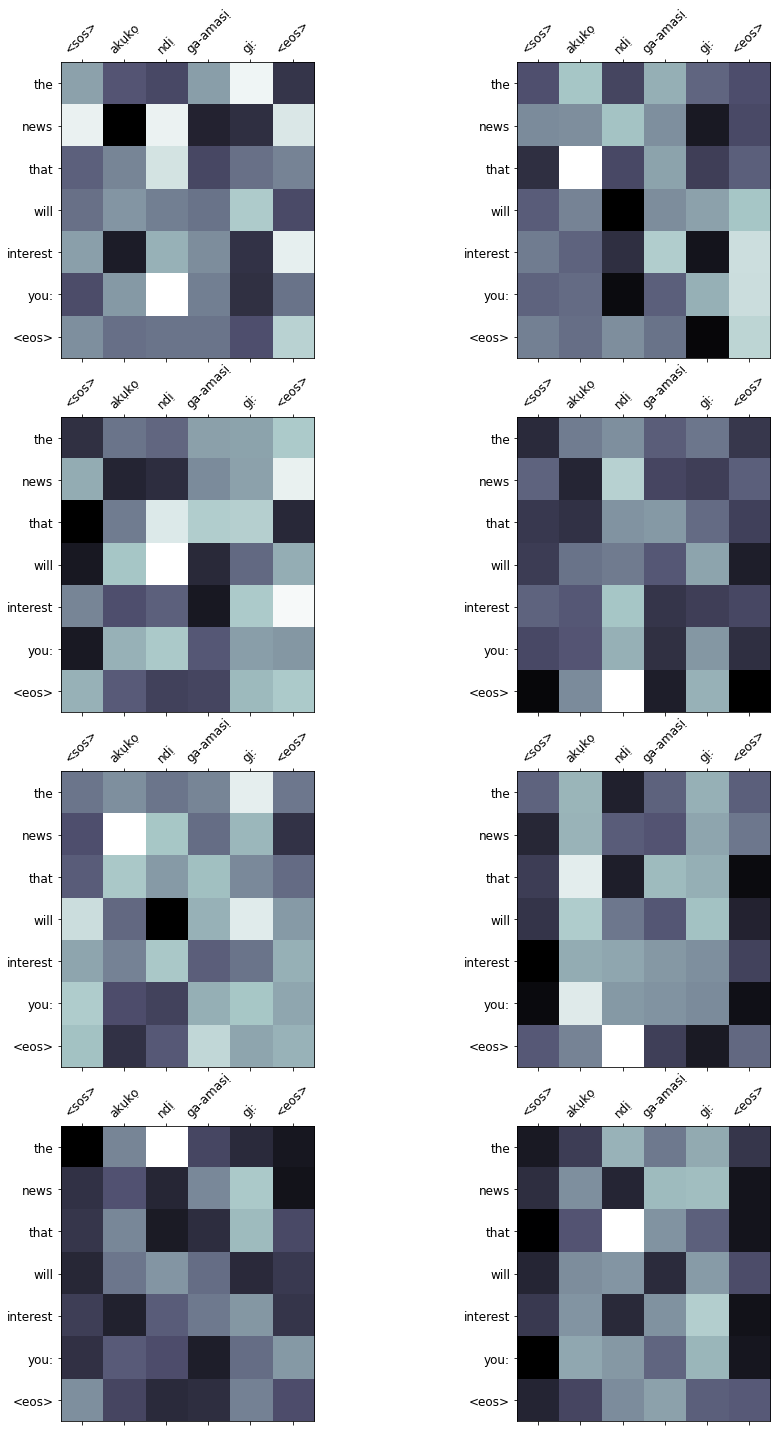

In [44]:
display_attention(src, translation, attention)

Translate an example from the validation data

In [45]:
example_idx = 0

src = vars(validate_data.examples[example_idx])['src']
trg = vars(validate_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['anyị', 'na-ewehie', 'ndozi', 'dịka', 'iwu']
trg = ['we', 'are', 'confusing', 'regulation', 'with', 'policy.']


Again, visualize the attention heads

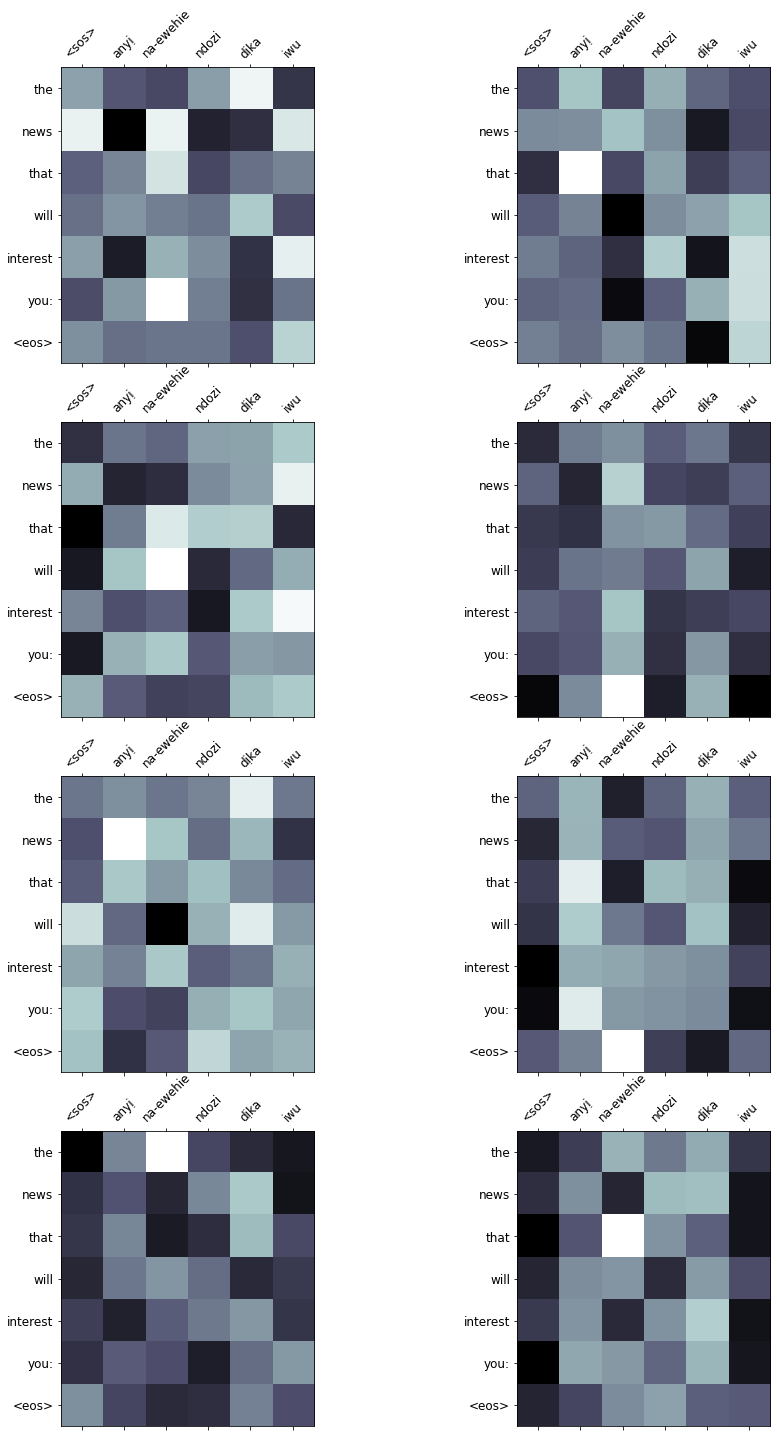

In [46]:
display_attention(src, translation, attention)

Translate an example from the test data

In [69]:
# example_idx = 300

src = 'O bu dokita .'.split() #vars(test_data.examples[example_idx])['src']
trg = 'He is a doctor .'.split() #vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['O', 'bu', 'dokita', '.']
trg = ['He', 'is', 'a', 'doctor', '.']
predicted trg = ['he', 'was', '<unk>', '<eos>']


Show attention heads

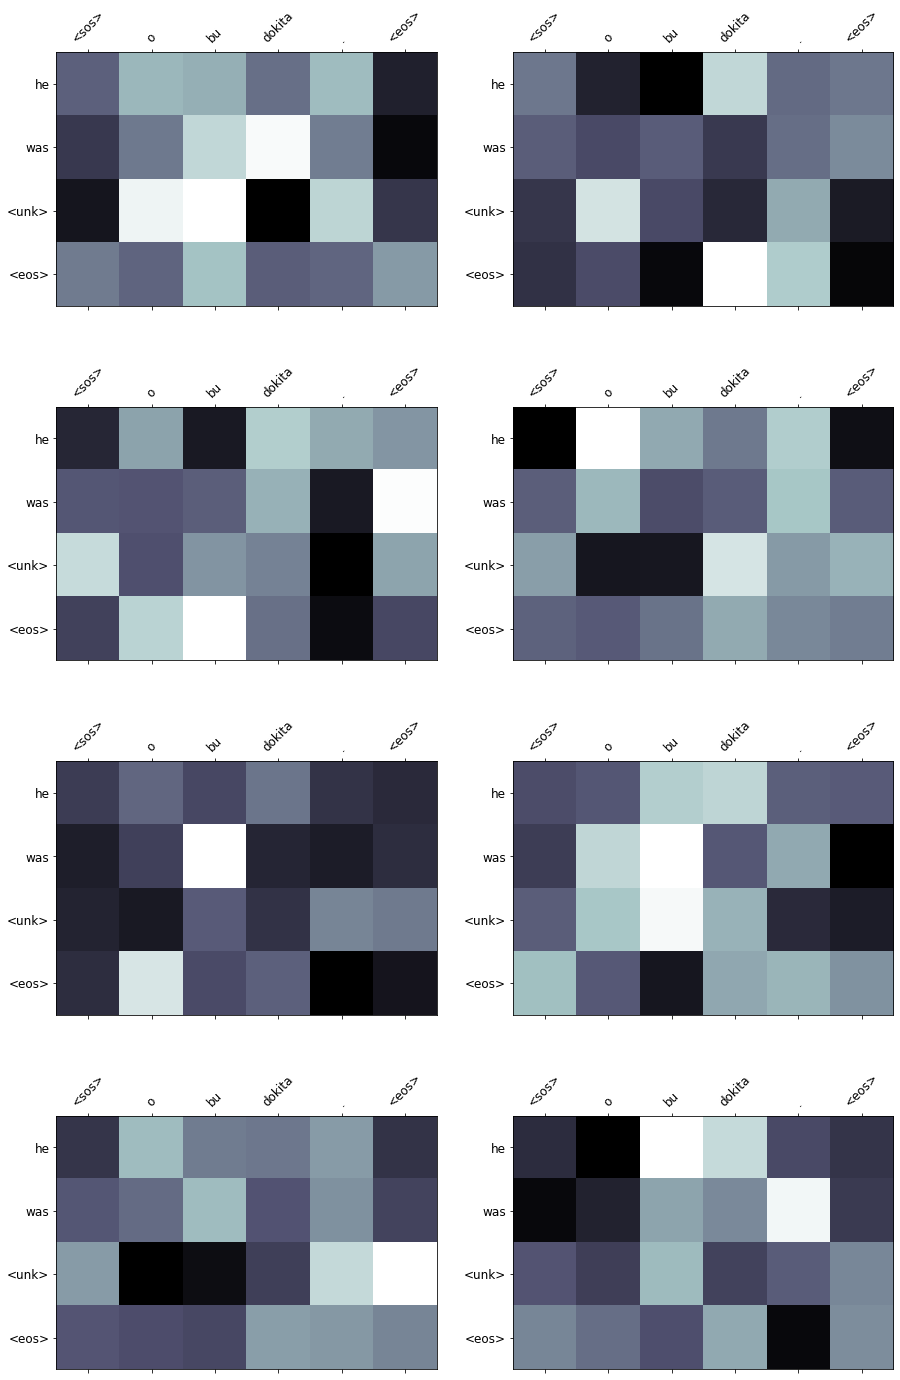

In [70]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [0]:
import torchtext

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [63]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

AttributeError: ignored